In [85]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline

# Loading data

In [86]:
X_data = pd.read_csv('data/train_data.csv')
X_data_test = pd.read_csv('data/1234.csv', sep=';')
X_data_ktest = pd.read_csv('data/test_data.csv')
y_data = pd.read_csv('data/train_target.csv', header=-1, names=['agreed'])

In [87]:
y_data_test = X_data_test['y']
X_data_test.drop(['y'], axis = 1, inplace = True, errors = 'ignore')

y_data_test = pd.DataFrame(y_data_test)
y_data_test['y'] = y_data_test.apply(lambda row: 1 if row['y'] == 'yes' else 0, axis=1)

In [88]:
print('Is everything ok?: ',  X_data.shape[0] == y_data.shape[0])
print('And duplicates?: ',  np.all(X_data.duplicated() == False))

Is everything ok?:  True
And duplicates?:  False


Checking if balanced sample:


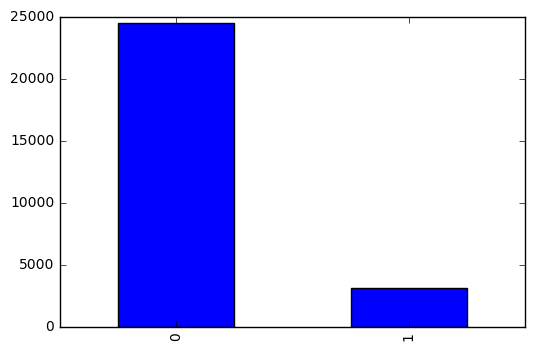

In [89]:
print('Checking if balanced sample:')
y_data['agreed'].value_counts().plot(kind='bar');

# Working with features

In [90]:
X_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.00000
mean,40.085994,258.874542,2.568328,962.693169,0.172024,0.087211,93.577443,-40.503026,3.628844,5167.31696
std,10.480548,260.511236,2.765561,186.371948,0.492548,1.567343,0.578193,4.616641,1.730084,72.22960
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.60000
25%,32.000000,101.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.10000
50%,38.000000,179.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.00000
75%,47.000000,320.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.10000
max,94.000000,4199.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.10000


In [91]:
def convert_features(data):
    conv_data = data.copy()
    
    conv_data['default'] = conv_data.apply(lambda row: 1 if row['default'] == 'yes' else 0, axis=1)
    
    conv_data['housing'] = conv_data.apply(lambda row: 1 if row['housing'] == 'yes' else 0, axis=1)
    
    conv_data['loan'] = conv_data.apply(lambda row: 1 if row['loan'] == 'yes' else 0, axis=1)
    
    # nominal values
    nom_df = conv_data[['poutcome', 'month', 'contact',
                        'education', 'day_of_week', 'job', 'marital']]
    conv_data = conv_data.drop(nom_df.columns, axis=1)
    nom_df = pd.get_dummies(nom_df)
    conv_data = pd.concat([conv_data, nom_df], axis = 1)
    
    # drop unused
    conv_data = conv_data.drop(['previous'], axis = 1)
    
    return conv_data

In [92]:
X_data = convert_features(X_data)

# Undersampling major feature

In [93]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [94]:
X_cols = X_data.columns

In [95]:
# smote = SMOTE(ratio='auto', kind='regular')
# X_data, y_data = smote.fit_sample(X_data, y_data['agreed'].values.ravel())

In [96]:
X_data = pd.DataFrame(X_data)
X_data.columns = X_cols
y_data = pd.DataFrame(y_data)
y_data.columns = ['agreed']

In [97]:
X_data.shape

(27595, 56)

In [98]:
# IHT = RandomUnderSampler()
# X_data, y_data = IHT.fit_sample(X_data, y_data['agreed'].values.ravel())

In [99]:
X_data = pd.DataFrame(X_data)
X_data.columns = X_cols
y_data = pd.DataFrame(y_data)
y_data.columns = ['agreed']

In [100]:
X_data.shape

(27595, 56)

# And updating test samples

In [101]:
X_data_test = convert_features(X_data_test)

In [102]:
X_data_ktest = convert_features(X_data_ktest)

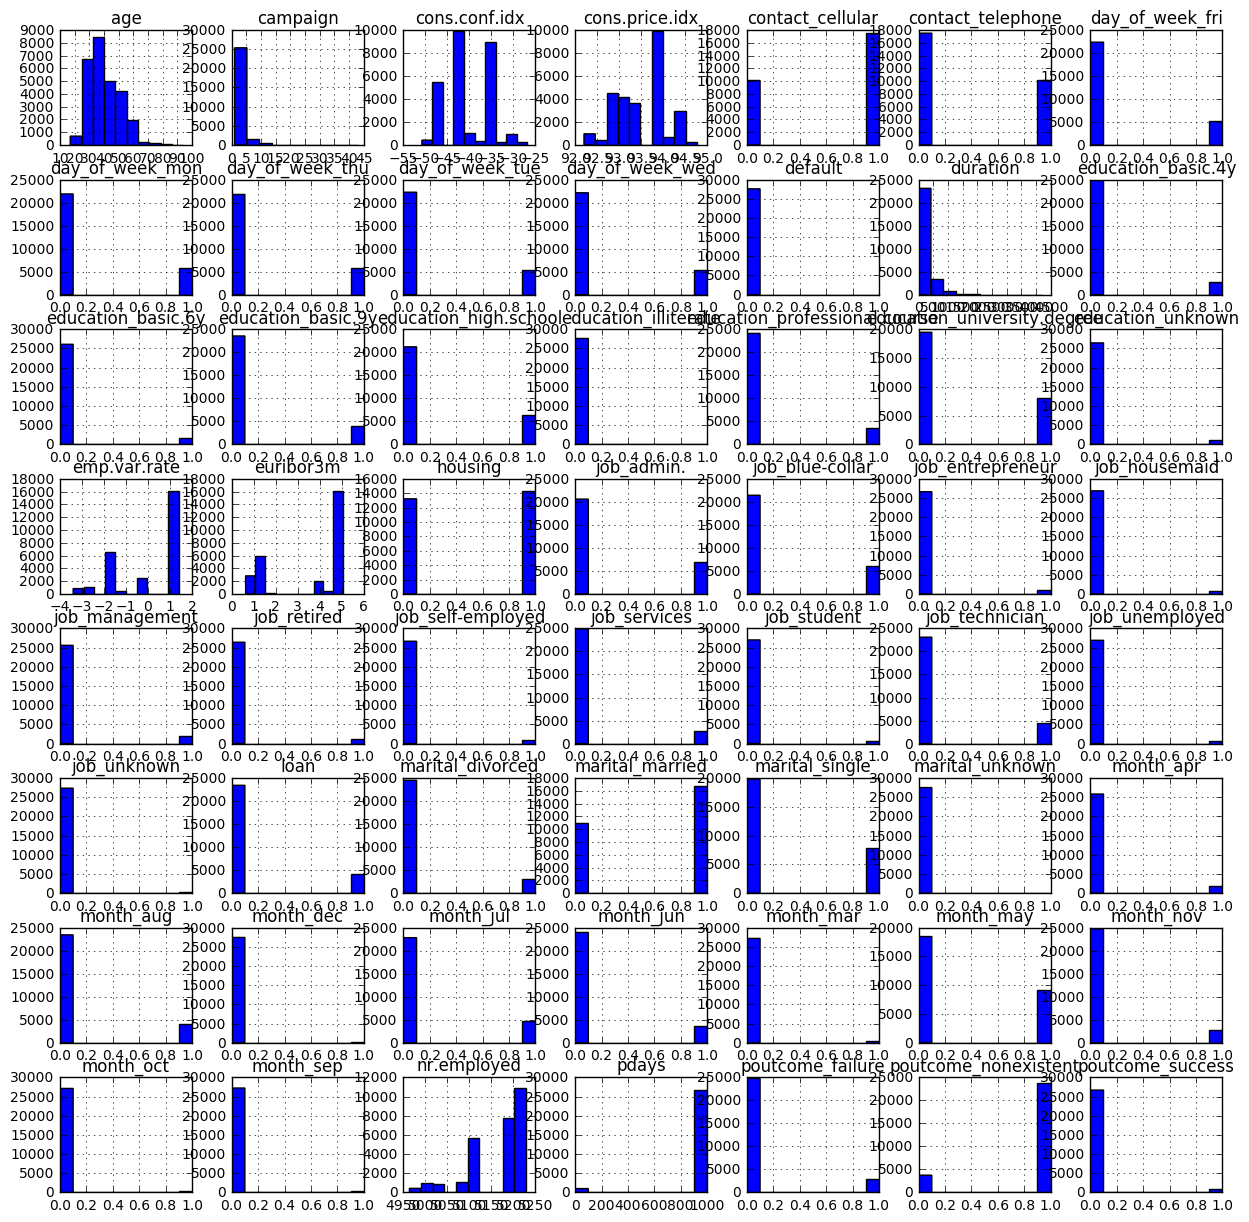

In [103]:
X_data.hist(figsize=(15, 15));

In [104]:
X_data.corrwith(y_data['agreed'])

age                              0.032164
default                         -0.003719
housing                          0.013259
loan                            -0.005903
duration                         0.408124
campaign                        -0.071472
pdays                           -0.326604
emp.var.rate                    -0.299526
cons.price.idx                  -0.136918
cons.conf.idx                    0.051229
euribor3m                       -0.308978
nr.employed                     -0.353859
poutcome_failure                 0.035771
poutcome_nonexistent            -0.197625
poutcome_success                 0.317511
month_apr                        0.079665
month_aug                       -0.013739
month_dec                        0.084182
month_jul                       -0.032084
month_jun                       -0.006353
month_mar                        0.142423
month_may                       -0.106588
month_nov                       -0.014832
month_oct                        0

# Splitting data into train/test sets

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
RANDOM_SEED = 34791
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data['agreed'].values, test_size=0.25, 
                 random_state = RANDOM_SEED, stratify=y_data['agreed'].values)

# Fitting models

In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [108]:
def top_importance_print(n, importances, importances_names):
    indexes = importances.argsort()[-n:][::-1]
    for i, index in enumerate(indexes):
        print ('#{} Important feature is -- {} with {:.2f} importance'.format(i + 1, importances_names[index], importances[index]))

## Random Forest

In [109]:
from sklearn.ensemble import RandomForestClassifier

In [110]:
kf = StratifiedKFold(n_splits = 5, random_state=RANDOM_SEED)
param = {'criterion':['gini', 'entropy'], 'max_features':[1, 5, 10, 15, 20, 25, 30, 'log2', 'auto'],
         'max_depth':[2, 4, 8, 16, 32, 64], 'class_weight':['balanced']}
cv = GridSearchCV(RandomForestClassifier(), param, scoring='roc_auc', n_jobs = -1, cv=kf)
cv.fit(X_train, y_train);
print('Best score: ', cv.best_score_)
print('Params: ', cv.best_params_)

Best score:  0.942024708637
Params:  {'max_depth': 8, 'class_weight': 'balanced', 'max_features': 20, 'criterion': 'entropy'}


In [111]:
y_t = cv.predict(X_test)
roc_auc_score(y_test, y_t)

0.87094481780731114

In [112]:
top_importance_print(10, cv.best_estimator_.feature_importances_, X_data.columns)

#1 Important feature is -- duration with 0.49 importance
#2 Important feature is -- nr.employed with 0.18 importance
#3 Important feature is -- euribor3m with 0.08 importance
#4 Important feature is -- emp.var.rate with 0.07 importance
#5 Important feature is -- cons.conf.idx with 0.04 importance
#6 Important feature is -- cons.price.idx with 0.02 importance
#7 Important feature is -- month_oct with 0.02 importance
#8 Important feature is -- age with 0.01 importance
#9 Important feature is -- month_may with 0.01 importance
#10 Important feature is -- pdays with 0.01 importance


In [29]:
y_t = cv.predict(X_data_test)
tt2 = cv.best_estimator_
roc_auc_score(y_data_test['y'].values, y_t)

0.88805072828174936

In [30]:
y_kpredicted = cv.predict(X_data_ktest)
y_kpredicted = pd.DataFrame(y_kpredicted)
y_kpredicted.columns = ['Prediction']
y_kpredicted.to_csv('hello.csv')

## SVC

In [31]:
from sklearn.svm import SVC

In [32]:
param_grid = {'C': np.linspace(0.01, 0.03, num=5), 
              'class_weight':['balanced'], 'kernel':['linear'],
              'decision_function_shape' : ['ovo', 'ovr', None], 'random_state' : [RANDOM_SEED]}
cv = GridSearchCV(SVC(), param_grid, n_jobs = -1, cv=kf)
cv.fit(X_train, y_train);

In [33]:
print('Best score: ', cv.best_score_)
print('Params: ', cv.best_params_)

Best score:  0.872190109184
Params:  {'kernel': 'linear', 'random_state': 34791, 'class_weight': 'balanced', 'C': 0.01, 'decision_function_shape': 'ovo'}


In [34]:
y_t = cv.predict(X_data_test)
roc_auc_score(y_data_test['y'].values, y_t)
tt = cv.best_estimator_

## AdaBoostClassifier

In [35]:
from sklearn.ensemble import AdaBoostClassifier

In [36]:
param = {'algorithm': ['SAMME.R', 'SAMME'], 'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0]}
cv = GridSearchCV(AdaBoostClassifier(), param, scoring="roc_auc", n_jobs = -1, cv=kf)
cv.fit(X_train, y_train);

In [37]:
print('Best score: ', cv.best_score_)
print('Params: ', cv.best_params_)

Best score:  0.937291964507
Params:  {'learning_rate': 1.0, 'algorithm': 'SAMME.R'}


In [38]:
y_t = cv.predict(X_data_test)
roc_auc_score(y_data_test['y'].values, y_t)

0.87100028823691467

## SGDClassifier

In [39]:
from sklearn.linear_model import SGDClassifier

In [40]:
param = {'penalty': ['none', 'l2', 'l1', 'elasticnet'], 'shuffle': [True, False], 'learning_rate' : ['constant', 'optimal', 'invscaling'], 
         'class_weight' : ['balanced'], 'eta0' : [0.01, 0.1, 0.5]}
cv = GridSearchCV(SGDClassifier(), param, scoring="roc_auc", n_jobs = -1, cv=kf)
cv.fit(X_train, y_train);

In [41]:
print('Best score: ', cv.best_score_)
print('Params: ', cv.best_params_)

Best score:  0.870792997007
Params:  {'eta0': 0.1, 'learning_rate': 'optimal', 'class_weight': 'balanced', 'shuffle': True, 'penalty': 'l1'}


In [42]:
y_t = cv.predict(X_data_test)
roc_auc_score(y_data_test['y'].values, y_t)

0.76274744266396954

## DecisionTreeClassifier

In [43]:
from sklearn.tree import DecisionTreeClassifier

In [44]:
param = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_features':[1, 5, 10, 15, 20, 25, 30, 'log2', 'auto'], 
         'class_weight' : ['balanced'], 'random_state':[RANDOM_SEED], 'presort':[True, False]}
cv = GridSearchCV(DecisionTreeClassifier(), param, scoring="roc_auc", n_jobs = -1, cv=kf)
cv.fit(X_train, y_train);

In [45]:
print('Best score: ', cv.best_score_)
print('Params: ', cv.best_params_)

Best score:  0.855061746066
Params:  {'presort': True, 'random_state': 34791, 'criterion': 'entropy', 'max_features': 25, 'splitter': 'best', 'class_weight': 'balanced'}


In [46]:
y_t = cv.predict(X_data_test)
roc_auc_score(y_data_test['y'].values, y_t)

0.88044258282919396

# BaggingClassifier

In [47]:
from sklearn.ensemble import BaggingClassifier

In [48]:
bag_svm = BaggingClassifier(tt, max_features=5,
                            n_estimators=30, random_state=RANDOM_SEED).fit(X_train, y_train)

In [49]:
y_t = bag_svm.predict(X_data_test)
roc_auc_score(y_data_test['y'].values, y_t)

0.72424548916304676

# GaussianNB

In [51]:
from sklearn.naive_bayes import GaussianNB

In [52]:
gnb = GaussianNB()
y_t = gnb.fit(X_train, y_train).predict(X_test)
roc_auc_score(y_test, y_t)

0.72180733984311829

In [53]:
y_t = gnb.predict(X_data_test)
roc_auc_score(y_data_test['y'].values, y_t)

0.72778008278201933

# KNeighborsClassifier

In [113]:
from sklearn.neighbors import KNeighborsClassifier

In [114]:
param = {'n_neighbors': [20, 30, 50, 70], 'weights': ['uniform', 'distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 
         'leaf_size' : [5, 10, 20, 30, 50], 'p':[1, 2]}
cv = GridSearchCV(KNeighborsClassifier(), param, scoring="roc_auc", n_jobs = -1, cv=kf, verbose=2)
cv.fit(X_train, y_train);

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV] algorithm=auto, leaf_size=5, weights=uniform, n_neighbors=20, p=1 
[CV] algorithm=auto, leaf_size=5, weights=uniform, n_neighbors=20, p=1 
[CV] algorithm=auto, leaf_size=5, weights=uniform, n_neighbors=20, p=1 
[CV] algorithm=auto, leaf_size=5, weights=uniform, n_neighbors=20, p=1 
[CV]  algorithm=auto, leaf_size=5, weights=uniform, n_neighbors=20, p=1 -   1.8s
[CV] algorithm=auto, leaf_size=5, weights=uniform, n_neighbors=20, p=1 
[CV]  algorithm=auto, leaf_size=5, weights=uniform, n_neighbors=20, p=1 -   1.9s
[CV] algorithm=auto, leaf_size=5, weights=distance, n_neighbors=20, p=1 
[CV]  algorithm=auto, leaf_size=5, weights=uniform, n_neighbors=20, p=1 -   1.9s
[CV] algorithm=auto, leaf_size=5, weights=distance, n_neighbors=20, p=1 
[CV]  algorithm=auto, leaf_size=5, weights=uniform, n_neighbors=20, p=1 -   2.0s
[CV] algorithm=auto, leaf_size=5, weights=distance, n_neighbors=20, p=1 
[CV]  algorithm=auto, leaf_size=5

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min


[CV]  algorithm=auto, leaf_size=5, weights=uniform, n_neighbors=30, p=2 -   2.3s
[CV] algorithm=auto, leaf_size=5, weights=distance, n_neighbors=30, p=2 
[CV]  algorithm=auto, leaf_size=5, weights=distance, n_neighbors=30, p=2 -   2.5s
[CV] algorithm=auto, leaf_size=5, weights=distance, n_neighbors=30, p=2 
[CV]  algorithm=auto, leaf_size=5, weights=distance, n_neighbors=30, p=2 -   1.9s
[CV] algorithm=auto, leaf_size=5, weights=uniform, n_neighbors=50, p=1 
[CV]  algorithm=auto, leaf_size=5, weights=distance, n_neighbors=30, p=2 -   1.8s
[CV] algorithm=auto, leaf_size=5, weights=uniform, n_neighbors=50, p=1 
[CV]  algorithm=auto, leaf_size=5, weights=distance, n_neighbors=30, p=2 -   1.8s
[CV] algorithm=auto, leaf_size=5, weights=uniform, n_neighbors=50, p=1 
[CV]  algorithm=auto, leaf_size=5, weights=distance, n_neighbors=30, p=2 -   2.0s
[CV] algorithm=auto, leaf_size=5, weights=uniform, n_neighbors=50, p=1 
[CV]  algorithm=auto, leaf_size=5, weights=uniform, n_neighbors=50, p=1 -  

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.9min


[CV]  algorithm=auto, leaf_size=10, weights=distance, n_neighbors=70, p=2 -   1.9s
[CV] algorithm=auto, leaf_size=10, weights=distance, n_neighbors=70, p=2 
[CV]  algorithm=auto, leaf_size=10, weights=distance, n_neighbors=70, p=2 -   1.9s
[CV]  algorithm=auto, leaf_size=10, weights=distance, n_neighbors=70, p=2 -   1.9s
[CV] algorithm=auto, leaf_size=20, weights=uniform, n_neighbors=20, p=1 
[CV] algorithm=auto, leaf_size=20, weights=uniform, n_neighbors=20, p=1 
[CV]  algorithm=auto, leaf_size=10, weights=distance, n_neighbors=70, p=2 -   2.0s
[CV] algorithm=auto, leaf_size=20, weights=uniform, n_neighbors=20, p=1 
[CV]  algorithm=auto, leaf_size=10, weights=distance, n_neighbors=70, p=2 -   1.9s
[CV] algorithm=auto, leaf_size=20, weights=uniform, n_neighbors=20, p=1 
[CV]  algorithm=auto, leaf_size=20, weights=uniform, n_neighbors=20, p=1 -   1.7s
[CV] algorithm=auto, leaf_size=20, weights=uniform, n_neighbors=20, p=1 
[CV]  algorithm=auto, leaf_size=20, weights=uniform, n_neighbors

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 17.5min


[CV]  algorithm=auto, leaf_size=50, weights=distance, n_neighbors=30, p=2 -   1.6s
[CV]  algorithm=auto, leaf_size=50, weights=distance, n_neighbors=30, p=2 -   1.7s
[CV] algorithm=auto, leaf_size=50, weights=uniform, n_neighbors=50, p=1 
[CV] algorithm=auto, leaf_size=50, weights=uniform, n_neighbors=50, p=1 
[CV]  algorithm=auto, leaf_size=50, weights=uniform, n_neighbors=50, p=1 -   2.3s
[CV] algorithm=auto, leaf_size=50, weights=uniform, n_neighbors=50, p=1 
[CV]  algorithm=auto, leaf_size=50, weights=uniform, n_neighbors=50, p=1 -   2.3s
[CV] algorithm=auto, leaf_size=50, weights=distance, n_neighbors=50, p=1 
[CV]  algorithm=auto, leaf_size=50, weights=uniform, n_neighbors=50, p=1 -   2.3s
[CV] algorithm=auto, leaf_size=50, weights=distance, n_neighbors=50, p=1 
[CV]  algorithm=auto, leaf_size=50, weights=uniform, n_neighbors=50, p=1 -   2.3s
[CV] algorithm=auto, leaf_size=50, weights=distance, n_neighbors=50, p=1 
[CV]  algorithm=auto, leaf_size=50, weights=uniform, n_neighbors=

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 42.7min


[CV]  algorithm=ball_tree, leaf_size=30, weights=uniform, n_neighbors=20, p=1 -   8.2s
[CV] algorithm=ball_tree, leaf_size=30, weights=uniform, n_neighbors=20, p=1 
[CV]  algorithm=ball_tree, leaf_size=30, weights=uniform, n_neighbors=20, p=1 -   7.7s
[CV]  algorithm=ball_tree, leaf_size=30, weights=uniform, n_neighbors=20, p=1 -   7.7s
[CV] algorithm=ball_tree, leaf_size=30, weights=distance, n_neighbors=20, p=1 
[CV] algorithm=ball_tree, leaf_size=30, weights=distance, n_neighbors=20, p=1 
[CV]  algorithm=ball_tree, leaf_size=30, weights=uniform, n_neighbors=20, p=1 -   4.2s
[CV] algorithm=ball_tree, leaf_size=30, weights=distance, n_neighbors=20, p=1 
[CV]  algorithm=ball_tree, leaf_size=30, weights=uniform, n_neighbors=20, p=1 -   3.7s
[CV] algorithm=ball_tree, leaf_size=30, weights=distance, n_neighbors=20, p=1 
[CV]  algorithm=ball_tree, leaf_size=30, weights=distance, n_neighbors=20, p=1 -   5.0s
[CV] algorithm=ball_tree, leaf_size=30, weights=distance, n_neighbors=20, p=1 
[CV]

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 77.8min


[CV]  algorithm=kd_tree, leaf_size=20, weights=distance, n_neighbors=50, p=1 -   2.9s
[CV] algorithm=kd_tree, leaf_size=20, weights=distance, n_neighbors=50, p=1 
[CV]  algorithm=kd_tree, leaf_size=20, weights=distance, n_neighbors=50, p=1 -   2.9s
[CV] algorithm=kd_tree, leaf_size=20, weights=uniform, n_neighbors=50, p=2 
[CV]  algorithm=kd_tree, leaf_size=20, weights=distance, n_neighbors=50, p=1 -   2.9s
[CV] algorithm=kd_tree, leaf_size=20, weights=uniform, n_neighbors=50, p=2 
[CV]  algorithm=kd_tree, leaf_size=20, weights=uniform, n_neighbors=50, p=2 -   1.9s
[CV] algorithm=kd_tree, leaf_size=20, weights=uniform, n_neighbors=50, p=2 
[CV]  algorithm=kd_tree, leaf_size=20, weights=uniform, n_neighbors=50, p=2 -   2.1s
[CV] algorithm=kd_tree, leaf_size=20, weights=uniform, n_neighbors=50, p=2 
[CV]  algorithm=kd_tree, leaf_size=20, weights=distance, n_neighbors=50, p=1 -   2.4s
[CV] algorithm=kd_tree, leaf_size=20, weights=uniform, n_neighbors=50, p=2 
[CV]  algorithm=kd_tree, leaf

KeyboardInterrupt: 

In [115]:
print('Best score: ', cv.best_score_)
print('Params: ', cv.best_params_)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
y_t = cv.predict(X_data_test)
roc_auc_score(y_data_test['y'].values, y_t)